In [1]:
################################ STORE ITEM DEMAND FORECASTING ####################################3

## İŞ PROBLEMİ : Bir mağaza zinciri, 10 farklı mağazası ve 50 farklı ürünü için 3 aylık bir talep tahmini istemektedir.

### VERİ SETİ HİKAYESİ
## Bir mağaza zincirinin 5 yıllık verilerinde 10 farklı mağazası ve 50 farklı ürünün bilgileri yer almaktadır.

### DEĞİŞKENLER
## date – Satış verilerinin tarihi (Tatil efekti veya mağaza kapanışı yoktur).
## Store – Mağaza ID’si (Her bir mağaza için eşsiz numara).
## Item – Ürün ID’si (Her bir ürün için eşsiz numara).
## Sales – Satılan ürün sayıları, (Belirli bir tarihte belirli bir mağazadan satılan ürünlerin sayısı).

### GÖREV
## Aşağıdaki zaman serisi ve makine öğrenmesi tekniklerini kullanarak ilgili mağaza zinciri için 3 aylık bir talep
## tahmin modeli oluşturunuz.
## Random Noise, Lag/Shifted Features, Rolling Mean Features, Exponentially Weighted Mean Features,
## Custom Cost Function (SMAPE), LightGBM ile Model Validation

In [2]:
## IMPORTING 

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')


In [3]:
### DATA SET

train = pd.read_csv("/kaggle/input/demand-forecast/train.csv", parse_dates=['date'])
test = pd.read_csv("/kaggle/input/demand-forecast/test.csv", parse_dates=['date'])
sample_sub = pd.read_csv("/kaggle/input/demand-forecast/sample_submission.csv")
df = pd.concat([train, test], sort=False)

In [4]:
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


In [5]:
### EDA

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
##################### Tail #####################
             date  store  item  sales
912995 2017-12-27     10    50     63
912996 2017-12-28     10    50     59
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item  

In [6]:
check_df(test)

##################### Shape #####################
(45000, 4)
##################### Types #####################
id                int64
date     datetime64[ns]
store             int64
item              int64
dtype: object
##################### Head #####################
   id       date  store  item
0   0 2018-01-01      1     1
1   1 2018-01-02      1     1
2   2 2018-01-03      1     1
3   3 2018-01-04      1     1
4   4 2018-01-05      1     1
##################### Tail #####################
          id       date  store  item
44995  44995 2018-03-27     10    50
44996  44996 2018-03-28     10    50
44997  44997 2018-03-29     10    50
44998  44998 2018-03-30     10    50
44999  44999 2018-03-31     10    50
##################### NA #####################
id       0
date     0
store    0
item     0
dtype: int64
##################### Quantiles #####################
       0.00     0.05     0.50      0.95      0.99     1.00
id      0.0  2249.95  22499.5  42749.05  44549.01  44999.0
sto

In [7]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
##################### NA #####################
date          0
store         0
item          0
sales     45000
id       913000
dtype: int64
##################

In [8]:
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [9]:
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
30%          33.000000
50%          47.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
99%         135.000000
max         231.000000
Name: sales, dtype: float64

In [10]:
df[["store"]].nunique()

store    10
dtype: int64

In [11]:
df[["item"]].nunique()

item    50
dtype: int64

In [12]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [13]:
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

In [14]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [15]:
### FEATURE ENGINEERING

def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['weekday'] = df.date.dt.weekday
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['quarter'] = df.date.dt.quarter
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    return df


df = create_date_features(df)

In [16]:
df.head()

,date,store,item,sales,id,month,day,week,day_of_month,day_of_year,week_of_year,day_of_week,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,1,1,1,2013,0,1,0,1,1,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,1,2,2,1,2,2,2013,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,1,3,3,1,3,3,2013,0,0,0,1,0,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,1,4,4,1,4,4,2013,1,0,0,1,0,0,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,1,5,5,1,5,5,2013,1,0,0,1,0,0,0,0


In [17]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                      sum       mean median        std
store item month                                      
1     1    1       2125.0  13.709677   13.0   4.397413
           2       2063.0  14.631206   14.0   4.668146
           3       2728.0  17.600000   17.0   4.545013
           4       3118.0  20.786667   20.0   4.894301
           5       3448.0  22.245161   22.0   6.564705
...                   ...        ...    ...        ...
10    50   8      13108.0  84.567742   85.0  15.676527
           9      11831.0  78.873333   79.0  15.207423
           10     11322.0  73.045161   72.0  14.209171
           11     11549.0  76.993333   77.0  16.253651
           12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [18]:
### RANDOM NOISE

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [19]:
### LAG/SHIFTED FEATURES

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df

,date,store,item,sales,id,month,day,week,day_of_month,day_of_year,week_of_year,day_of_week,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,1,2,2,1,2,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,1,3,3,1,3,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,1,4,4,1,4,4,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,1,5,5,1,5,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,13,27,86,13,1,1,2018,0,0,0,1,0,0,0,0,40.648666,56.207341,69.300606,69.208137,66.720595,79.893096,77.413831,60.534137,95.434308,73.779885
44996,2018-03-28,10,50,NaN,44996.0,3,28,13,28,87,13,2,2,2018,0,0,0,1,0,0,0,0,61.708555,51.459616,64.984735,58.621824,76.131862,78.999558,83.429752,74.018619,75.787543,68.587097
44997,2018-03-29,10,50,NaN,44997.0,3,29,13,29,88,13,3,3,2018,0,0,0,1,0,0,0,0,60.118302,65.505133,70.040332,65.656168,71.373144,89.710969,83.222123,67.742209,98.840319,74.367738
44998,2018-03-30,10,50,NaN,44998.0,3,30,13,30,89,13,4,4,2018,1,0,0,1,0,0,0,0,74.089058,75.530311,71.733522,66.695964,62.729315,79.063273,88.739930,70.252423,80.161389,81.888324


In [20]:
check_df(df)

##################### Shape #####################
(958000, 32)
##################### Types #####################
date                datetime64[ns]
store                        int64
item                         int64
sales                      float64
id                         float64
month                        int64
day                          int64
week                         int64
day_of_month                 int64
day_of_year                  int64
week_of_year                 int64
day_of_week                  int64
weekday                      int64
year                         int64
is_wknd                      int64
is_month_start               int64
is_month_end                 int64
quarter                      int64
is_quarter_start             int64
is_quarter_end               int64
is_year_start                int64
is_year_end                  int64
sales_lag_91               float64
sales_lag_98               float64
sales_lag_105              float64
sales_lag_11

In [21]:
### ROLLING MEAN FEATURES

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])

df.head()

,date,store,item,sales,id,month,day,week,day_of_month,day_of_year,week_of_year,day_of_week,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,1,2,2,1,2,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,1,3,3,1,3,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,1,4,4,1,4,4,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,1,5,5,1,5,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.tail()

,date,store,item,sales,id,month,day,week,day_of_month,day_of_year,week_of_year,day_of_week,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,13,27,86,13,1,1,2018,0,0,0,1,0,0,0,0,40.648666,56.207341,69.300606,69.208137,66.720595,79.893096,77.413831,60.534137,95.434308,73.779885,90.253215,85.746842
44996,2018-03-28,10,50,NaN,44996.0,3,28,13,28,87,13,2,2,2018,0,0,0,1,0,0,0,0,61.708555,51.459616,64.984735,58.621824,76.131862,78.999558,83.429752,74.018619,75.787543,68.587097,86.545472,85.813562
44997,2018-03-29,10,50,NaN,44997.0,3,29,13,29,88,13,3,3,2018,0,0,0,1,0,0,0,0,60.118302,65.505133,70.040332,65.656168,71.373144,89.710969,83.222123,67.742209,98.840319,74.367738,88.674876,86.566731
44998,2018-03-30,10,50,NaN,44998.0,3,30,13,30,89,13,4,4,2018,1,0,0,1,0,0,0,0,74.089058,75.530311,71.733522,66.695964,62.729315,79.063273,88.739930,70.252423,80.161389,81.888324,89.672135,87.432784
44999,2018-03-31,10,50,NaN,44999.0,3,31,13,31,90,13,5,5,2018,1,0,1,1,0,1,0,0,63.726822,70.188872,50.432349,67.567419,53.171388,78.860526,103.528057,101.570598,97.197291,84.190969,87.733470,87.247879


In [23]:
### EXPONENTIALLY WEIGHTED MEAN FEATURES

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

check_df(df)

##################### Shape #####################
(958000, 79)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 79, dtype: object
##################### Head #####################
        date  store  item  sales  id  month  day  week  day_of_month  day_of_year  week_of_year  day_of_week  weekday  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag

In [24]:
### ONE-HOT ENCODING

df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

df.head()

,date,sales,id,day,week,day_of_month,day_of_year,week_of_year,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,1,4,4,1,4,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [25]:
df.shape

(958000, 154)

In [26]:
# Converting sales to log(1+sales)

df['sales'] = np.log1p(df["sales"].values)
check_df(df)

##################### Shape #####################
(958000, 154)
##################### Types #####################
date        datetime64[ns]
sales              float64
id                 float64
day                  int64
week                 int64
                 ...      
month_8              uint8
month_9              uint8
month_10             uint8
month_11             uint8
month_12             uint8
Length: 154, dtype: object
##################### Head #####################
        date     sales  id  day  week  day_of_month  day_of_year  week_of_year  weekday  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  sales_lag_91  sales_lag_98  sales_lag_105  sales_lag_112  sales_lag_119  sales_lag_126  sales_lag_182  sales_lag_364  sales_lag_546  sales_lag_728  sales_roll_mean_365  sales_roll_mean_546  sales_ewm_alpha_095_lag_91  sales_ewm_alpha_095_lag_98  sales_ewm_alpha_095_lag_105  \
0 2013-01-01  2.639057 NaN    1

In [27]:
df.head()

,date,sales,id,day,week,day_of_month,day_of_year,week_of_year,weekday,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,3,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,4,1,4,4,1,4,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,

In [28]:
### CUSTOM COST FUNCTION

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [29]:
# TIME-BASED VALIDATION SETS

# 2017'nin 10.ayına kadar train seti.
train = df.loc[(df["date"] < "2017-10-01"), :]

In [30]:
## 2017'nın son 3 ayını da valıdasyon setı olarak olusturalım.
val = df.loc[(df["date"] >= "2017-10-01") & (df["date"] < "2017-12-31"), :]

In [31]:
## ındependent varıables

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [32]:
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((867000,), (867000, 150), (45500,), (45500, 150))

In [33]:
# LIGHTGBM PARAMETERS

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [34]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.422063 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.169458	training's SMAPE: 17.2745	valid_1's l1: 0.149682	valid_1's SMAPE: 15.2663
[200]	training's l1: 0.139663	training's SMAPE: 14.2975	valid_1's l1: 0.130607	valid_1's SMAPE: 13.3527
[300]	training's l1: 0.134531	training's SMAPE: 13.784	valid_1's l1: 0.12883	valid_1's SMAPE: 13.1747
[400]	training's l1: 0.132613	training's SMAPE: 13.5927	valid_1's l1: 0.127389	valid_1's SMAPE: 13.0303
[500]	training's l1: 0.131446	training's SMAPE: 13.4763	valid_1's l1: 0.126345	valid_1's SMAPE: 12.9255
[600]	training's l1: 0.130594	training's SMAPE: 13.3911	valid_1's l1: 0.125666	valid_1's SMAPE: 12.8571
[700]	training's l1: 0.129928	training's SMAPE: 13.3245	valid_1's l1: 0.125159	valid_1's SMAPE: 12.8062
[800]	training's l1: 0.129384	training's SMAPE:

In [35]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [36]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

12.699908023079123

In [37]:
### FEATURE IMPORTANCE

def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30)

                         feature  split       gain
25           sales_roll_mean_546    984  55.599667
21                 sales_lag_364   1391  13.266967
24           sales_roll_mean_365    641   5.675938
68    sales_ewm_alpha_05_lag_365    391   4.576125
53     sales_ewm_alpha_07_lag_91     31   3.987996
62     sales_ewm_alpha_05_lag_91     87   1.844785
5                        weekday    488   1.689082
26    sales_ewm_alpha_095_lag_91     65   1.582391
59    sales_ewm_alpha_07_lag_365     58   1.578778
3                    day_of_year    599   1.531653
14                  sales_lag_91     61   1.066199
149                     month_12    293   0.869254
1                           week    212   0.803552
52    sales_ewm_alpha_08_lag_728     29   0.605876
61    sales_ewm_alpha_07_lag_728     66   0.602976
70    sales_ewm_alpha_05_lag_728    343   0.589180
15                  sales_lag_98     20   0.539987
35     sales_ewm_alpha_09_lag_91     29   0.532697
131                day_of_week_

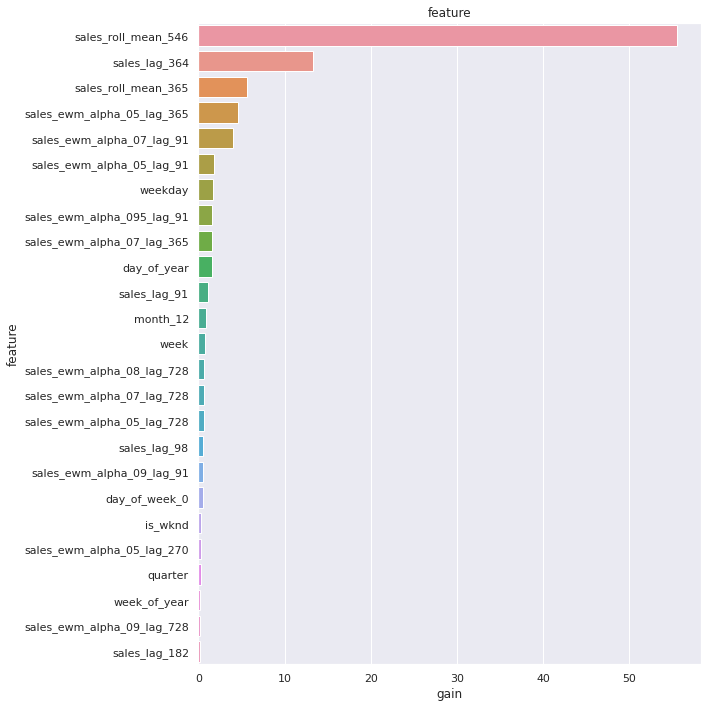

In [38]:
plot_lgb_importances(model, num=30, plot=True)

In [39]:
### FİNAL MODEL

train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [40]:
# LightGBM dataset

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [41]:
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.459070 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [42]:
test_preds = model.predict(X_test, num_iteration=model.best_iteration)
test_preds

array([2.59347388, 2.67490747, 2.68189167, ..., 4.35959346, 4.41117061,
       4.48615378])

In [43]:
## create submission for kaggle challenge 

submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.to_csv('submission_demand.csv', index=False)
submission_df.head(20)

,id,sales
0,0,12.376158
1,1,13.511007
2,2,13.612710
3,3,14.423090
4,4,16.579625
5,5,18.445381
6,6,20.507619
7,7,12.196615
8,8,13.918436
9,9,13.773640
